Имя: Пессима Сар Чанияма

Группа: 234-321

# Использование предобученных моделей

Задание: собрать датасет и использовать перенос обучения для решения задачи классификации.

## Порядок выполнения

1. Скачать изображения для создания датасета. Как структурировать папки подсмотрите в работе по ConvNet в датасете с Симпсонами;
1. Подготовить transforms, DataSet и DataLoader;
1. Выбрать одну из моделей в библиотеке timm;
1. Использовать на этой модели прием выделения признаков;
1. Использовать на этой модели прием дообучения (fine-tune);
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Туториал от Pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
1. [GitHub pytorch-image-models](https://github.com/huggingface/pytorch-image-models)
1. [Извлечение признаков](https://huggingface.co/docs/timm/feature_extraction)
1. [Which image models are best?](https://www.kaggle.com/code/jhoward/which-image-models-are-best)
1. [Pytorch Image Models (timm)](https://timm.fast.ai/)
1. [huggingface docs timm](https://huggingface.co/docs/hub/timm)

## Создание датасета

В этом задании вам надо собрать собственный датасет из изображений. В нем должно быть минимум 30 изображений для каждого класса. Количество классов не менее 2. Тематику датасета вы выбираете самостоятельно.

Далее в этом разделе приведен пример кода, который помогает скачать изображения по запросу на гугл диск. Вы можете решить эту задачу другими удобными для вас способами, в том числе и вручную.

Если вы работаете с локальной средой, то код из примера придется модифицировать.

In [1]:
# Установка пакета для работы с API поисковика DuckDuckGo

!pip install -U duckduckgo_search

In [2]:
from duckduckgo_search import DDGS

def scrap_images(query, n_results=40):
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(
            query,
            region="wt-wt",
            size="Medium",
            type_image="photo",
            max_results=n_results,
        )
        return [r['image'] for r in ddgs_images_gen]

In [3]:
CLASSES = ["owl", "house", "water bottle"]
urls = {x: scrap_images(x, 50) for x in CLASSES}

In [4]:
# монтируем гугл диск к среде, чтобы можно было записывать и считывать изображения
# в постоянное хранилище на гугл диске. Колаб попросит предоставить доступ.

from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR = "/content/drive/My Drive/dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
from pathlib import Path as P
import requests
from concurrent.futures import ThreadPoolExecutor

def download_files(urls, label, target_dir):
    def download_1(u, label):
        os.system(f"wget -P '{P(target_dir) / label}' '{u.strip()}'")
        print(f"wget -P '{P(target_dir) / label}' '{u.strip()}'")
    os.makedirs(target_dir, exist_ok=True)
    with ThreadPoolExecutor() as executor:
        for i, url in enumerate(urls):
            executor.submit(download_1, url, label)


for cls in CLASSES:
    download_files(urls[cls], cls, ROOT_DIR)

In [6]:
import shutil as sh
from pathlib import Path as P

dataset_s = len([*P(ROOT_DIR).glob('owl/*')])
train_s = int(dataset_s * 0.8)
test_s = dataset_s - train_s

[(P(ROOT_DIR) / x).mkdir(exist_ok=True) for x in ('test', 'train')]
[(P(ROOT_DIR) / x / cls ).mkdir(exist_ok=True) for cls in CLASSES for x in ('test', 'train')]

for cls in CLASSES:
    for f in [*P(ROOT_DIR).glob(f"{cls}/*")][:test_s]:
        sh.copy(f, P(ROOT_DIR) / 'test' / cls)
    for f in [*P(ROOT_DIR).glob(f"{cls}/*")][test_s:train_s]:
        sh.copy(f, P(ROOT_DIR) / 'train' / cls)

In [7]:
print(train_s, test_s)

39 10


В результате работы по этому разделу у вас должен получиться датасет. Проверьте что все скачанные изображения открываются и удалите поврежденные файлы. Изображения стоит разделить в папках на train и test и примерном соотношении 80 и 20%.

Доступ к вашему датасету потребуется открыть. Если вы скачивали изображения локально, то их надо будет выгрузить на гугл или яндекс диск.

**Ссылка на ваш датасет** - https://drive.google.com/drive/folders/1637zdyWv5FxkdtutJ94vCOaNJJRJZRAG?usp=sharing

**Описание вашего датасета:**

* Общее описание решаемой задачи: классификация изображений сов, домов и бутылок воды.
* Количество классов: 3
* Имена классов: "owl", "house", "water bottle"
* Количество изображений в каждом классе в обучающей и тестовой выборках: 40 / 10.

## Импортирование модулей

In [8]:
# по необходимости добавляйте свои модули

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')

# Не забывайте про .to(device)

Работаем на GPU


## Выбор модели из timm

В источниках к заданию, вы найдете список моделей, который выложен на github и [сравнение части моделей из timm](https://www.kaggle.com/code/jhoward/which-image-models-are-best). Вам необходимо остановить свой выбор на одной из них. В списке моделей на github есть ссылки на статьи о них, где можно найти информацию на каком датасете они были обучены.

Если вы работаете с фотографиями выбор можно остановить на одной из:
1. MobileNet,
1. VGG,
1. ResNet,
1. Xception.

По желанию можете попробовать несколько и сравнить.


In [10]:
# сначала требуется установить сам модуль timm
!pip install timm

In [11]:
import timm

In [12]:
# вывод списка моделей содержащих *resnet* и предобученных
[x for x in timm.list_models("*resnet*", pretrained=True) if 'ser' in x]

['legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'seresnet33ts.ra2_in1k',
 'seresnet50.a1_in1k',
 'seresnet50.a2_in1k',
 'seresnet50.a3_in1k',
 'seresnet50.ra2_in1k',
 'seresnet152d.ra2_in1k']

In [13]:
# в качестве первого аргумента укажите имя выбранной модели
# и не забудьте указать, предобученный вариант (pretrained)
pretrained_model = timm.create_model('seresnet50.a1_in1k', pretrained=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
# Вывод архитектуры модели
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

В описании архитектуры модели в выводе предыдущей ячейки, найдите два новых модуля (Conv2d, ReLU вы уже знаете) и добавьте их описание.

**Ваш ответ:**

1. PreActBottleneck

2. BatchNormAct2d

**Почему решили выбрать именно эту модель?**

Ваш ответ: мне посоветовал одногруппник.

In [15]:
help(nn.BatchNorm2d)

Help on class BatchNorm2d in module torch.nn.modules.batchnorm:

class BatchNorm2d(_BatchNorm)
 |  BatchNorm2d(num_features: int, eps: float = 1e-05, momentum: Optional[float] = 0.1, affine: bool = True, track_running_stats: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies Batch Normalization over a 4D input.
 |  
 |  4D is a mini-batch of 2D inputs
 |  with additional channel dimension. Method described in the paper
 |  `Batch Normalization: Accelerating Deep Network Training by Reducing
 |  Internal Covariate Shift <https://arxiv.org/abs/1502.03167>`__ .
 |  
 |  .. math::
 |  
 |      y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
 |  
 |  The mean and standard-deviation are calculated per-dimension over
 |  the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
 |  of size `C` (where `C` is the input size). By default, the elements of :math:`\gamma` are set
 |  to 1 and the elements of :math:`\beta` are

## Создание Dataset и DataLoader

По аналогии с прошлыми заданиями нам требуется создать transforms, которые передаются в создаваемый Dataset и из датасета вы создаете DataLoaders.

Данных у нас немного, поэтому мы не будем выделять валидационную часть.

При создании transforms помните, что модель ожидает на вход тензор определенной размерности. В [описание моделей](https://paperswithcode.com/lib/timm), вы можете найти датасет, на котором обучалась модель и есть описание размера изображений.

Для работы вам пригодится:

- v2.ToImage()
- v2.Resize() или v2.RandomResizedCrop() - размер изображения после кадрирования, должен быть равен размеру ожидаемому на ходе предобученной модели.
- v2.RandomRotation()
- v2.RandomHorizontalFlip()
- v2.ToDtype()

[Описания в документации](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


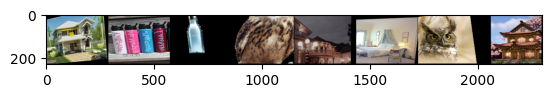

In [16]:
IMAGE_SIZE = (224, 285)

classes=CLASSES

transforms_train = v2.Compose([
    v2.ToImage(),
    v2.RandomPerspective(distortion_scale=0.3, p=1.0),
    v2.RandomRotation(10),
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop(size=IMAGE_SIZE, antialias=True),
    v2.ToTensor(),
    lambda x: (x / 255)
])
transforms_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
    v2.Resize(size=IMAGE_SIZE, antialias=True),
    v2.ToTensor(),
    lambda x: (x / 255),
])

train_dataset = ImageFolder(root="drive/MyDrive/dataset/train", transform=transforms_train)
test_dataset = ImageFolder(root="drive/MyDrive/dataset/test", transform=transforms_test)

BATCH_SIZE = 2**3

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE // 2)

inputs, classes = next(iter(train_loader))

out = torchvision.utils.make_grid(inputs)
out = torch.permute(out, (1,2,0))

plt.imshow(out, label=[classes[x] for x in classes])

**Почему выбрали именно такие преобразования (transforms) для данных?**

Ваш ответ: Я выбрал такие преобразования, потому что они добавляют разнообразие в данные, не делая изображения непонятными. Например, RandomPerspective и повороты немного меняют картинку, но она остается узнаваемой. Я исключил слишком сильные изменения, которые могли бы полностью испортить изображение. Для тестовых данных я оставил только простые преобразования, чтобы оценить модель на реалистичных примерах.

## Прием извлечения признаков

Этот прием может использоваться как сам по себе, так и быть предварительным этапом для дообучения.

Он заключается в том, что мы заменяем полносвязную часть модели (head/голову) на свою с учетом размерностей выходных данных из сверточной части и количеством классов в текущей задаче. Перед обучением требуется "заморозить" параметры сверточных слоев.

**Почему требуется "заморозка" параметров?**

Ваш ответ: Эти параметры, представляющие из себя ядра свертки и определяющие различные характеристики изображения, уже обучены на обширном наборе данных. Теперь требуется обучить классификатор, который работает с высокоуровневыми признаками, так как ему предстоит определять нужные классы.


У модели вы можете использовать метод .parameters(), он возвращает итерируемый объект с параметрами вашей модели. Вы можете их перебрать и отключить необходимость расчета градиентов.

In [17]:
# "Замораживаем" веса
for param in pretrained_model.parameters():
    param.requires_grad = False

# Заменяем "голову"
# .fc для вашей модели может иметь другое имя
# В nn.Sequential добавьте 1-2 скрытых слоя (nn.Linear, nn.ReLU)
pretrained_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 3),
)

pretrained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lr=1e-1, params=pretrained_model.parameters())

В этой работе также рассмотрим применение планировщика для изменения скорости обучения. Ранее у вас скорость обучения была константой, теперь же в процессе обучения каждые n эпох будем ее снижать.



In [19]:
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=2)

### Обучение и тестирование

Несколько эпох обучите модель в таком состоянии. Для обучения используйте уже знакомый вам цикл с эпохами и перебором dataloader, но к нему в цикл эпох требуется добавить шаг планировщика scheduler.step().

Не забывайте переключать режимы моделей (pretrained_model.train(), pretrained_model.eval()), так как теперь в них может быть пакетная нормализация и используйте контекст torch.no_grad() при проверке модели.

In [20]:
import numpy as np

In [21]:
logs = []

In [22]:
num_epochs = 10
logs.append({
    'num_epochs': num_epochs,
    'accuracy': [],
    'loss': []
})
log = logs[-1]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        pretrained_model.train()
        fwd = pretrained_model.forward(images)
        loss = loss_fn(fwd, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    print(f'E {epoch:2d},  loss: {loss.item():.3f}')
    scheduler.step()
    pretrained_model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            fwd = pretrained_model.forward(images)
            classindex = torch.max(fwd.data, dim=1)[1]
            total += labels.size(dim=0)
            correct += (classindex == labels).sum().detach()

        accuracy = (100 * correct / total).cpu()
        print(f'Accuracy: {accuracy:.2f}%')
        log['accuracy'].append(accuracy)
        log['loss'].append(loss.item())

E  0,  loss: 12.724
Accuracy: 42.86%
E  1,  loss: 2.655
Accuracy: 96.43%
E  2,  loss: 1.412
Accuracy: 100.00%
E  3,  loss: 0.001
Accuracy: 96.43%
E  4,  loss: 0.000
Accuracy: 92.86%
E  5,  loss: 1.926
Accuracy: 96.43%
E  6,  loss: 0.000
Accuracy: 96.43%
E  7,  loss: 1.595
Accuracy: 96.43%
E  8,  loss: 1.117
Accuracy: 96.43%
E  9,  loss: 1.687
Accuracy: 96.43%


In [23]:
log['accuracy']

[tensor(42.8571),
 tensor(96.4286),
 tensor(100.0000),
 tensor(96.4286),
 tensor(92.8571),
 tensor(96.4286),
 tensor(96.4286),
 tensor(96.4286),
 tensor(96.4286),
 tensor(96.4286)]

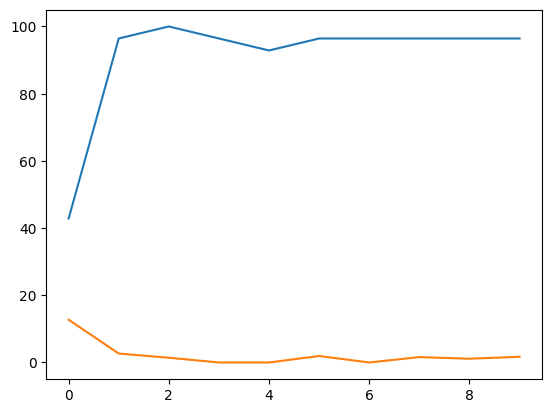

In [24]:
plt.plot(log['accuracy'])
plt.plot(log['loss'])
plt.show()

## Прием дообучения

Чтобы дообучить модель, требуется разморозить параметры модели. Для упрощения можете разморозить все параметры модели, но более правильно будет разморозить параметры 1-2 последних слоев и оптимизировать их, и наиболее сложный вариант разморозить больше 2 слоев, но использовать сниженные скорости обучения для более ранних слоев модели - [TORCH.OPTIM](https://pytorch.org/docs/stable/optim.html#per-parameter-options).

In [25]:
# Первый вариант
# for param in ___:
    #param...

# Второй вариант
pretrained_model.layer1[-1:].requires_grad_(True)

# Третий вариант
# model.blocks[-n:].requires_grad_(True)
# optim.SGD([
#                 {'params': model.base.parameters()},
#                 {'params': model.classifier.parameters(), 'lr': 1e-3}
#             ], lr=1e-2, momentum=0.9)

Sequential(
  (2): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_block): Identity()
    (act2): ReLU(inplace=True)
    (aa): Identity()
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEModule(
      (fc1): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
      (bn): Identity()
      (act): ReLU(inplace=True)
      (fc2): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
      (gate): Sigmoid()
    )
    (act3): ReLU(inplace=True)
  )
)

In [26]:
# Новый набор объектов

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lr=1e-02, params=pretrained_model.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size=2)

In [27]:
logs_2 = []

In [28]:
num_epochs = 10
logs_2.append({
    'num_epochs': num_epochs,
    'accuracy': [],
    'loss': []
})
log = logs_2[-1]

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        pretrained_model.train()
        fwd = pretrained_model.forward(images)
        loss = loss_fn(fwd, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    print(f'E {epoch:2d},  loss: {loss.item():.3f}')
    scheduler.step()
    pretrained_model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            fwd = pretrained_model.forward(images)
            classindex = torch.max(fwd.data, dim=1)[1]
            total += labels.size(dim=0)
            correct += (classindex == labels).sum().detach()

        accuracy = (100 * correct / total).cpu()
        print(f'Accuracy: {accuracy:.2f}%')
        log['accuracy'].append(accuracy)
        log['loss'].append(loss.item())

E  0,  loss: 0.001
Accuracy: 100.00%
E  1,  loss: 0.133
Accuracy: 100.00%
E  2,  loss: 0.000
Accuracy: 100.00%
E  3,  loss: 0.039
Accuracy: 100.00%
E  4,  loss: 2.984
Accuracy: 100.00%
E  5,  loss: 0.000
Accuracy: 100.00%
E  6,  loss: 0.016
Accuracy: 100.00%
E  7,  loss: 0.004
Accuracy: 100.00%
E  8,  loss: 0.435
Accuracy: 100.00%
E  9,  loss: 1.138
Accuracy: 100.00%


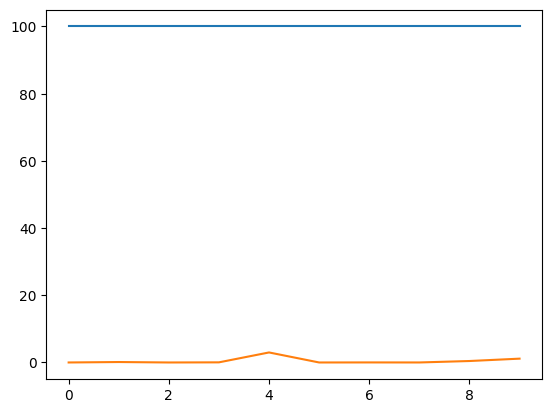

In [29]:
plt.plot(log['accuracy'])
plt.plot(log['loss'])
plt.show()

Скачайте одно новое изображение, которое можно отнести к одному из ваших классов, и классифицируйте его с помощью полученной модели.

In [30]:
sh.rmtree(P(ROOT_DIR) / 'test2')

In [31]:
qs = {'owl': 'сова', 'house': 'дом', 'water bottle': 'бутылка воды'}
[download_files(scrap_images(qs[cls], 10), cls, P(ROOT_DIR) / 'test2') for cls in CLASSES]

wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://cdn.pixabay.com/photo/2022/04/17/19/20/eurasian-pygmy-owl-7138809_1280.jpg'
wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://png.pngtree.com/background/20230528/original/pngtree-beautiful-owl-desktop-wallpapers-for-android-picture-image_2778850.jpg'
wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://farm2.staticflickr.com/1681/25540270343_da961210c0_n.jpg'
wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://c.pxhere.com/photos/c0/21/birds_owl_raptor_animal_animals_nature_eye-705197.jpg!s'
wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://i.pinimg.com/originals/3a/38/5c/3a385c8983dd906605daae445612d83a.jpg'
wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://imgpng.ru/d/owl_PNG46.png'
wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://99px.ru/sstorage/53/2020/11/mid_317662_416807.jpg'
wget -P '/content/drive/My Drive/dataset/test2/owl' 'https://zastavok.net/ts/animal

[None, None, None]

In [32]:
final_dataset = ImageFolder(root="drive/MyDrive/dataset/test2", transform=transforms_test)
final_loader = DataLoader(final_dataset, batch_size=6)

## Финал

Осталось попробовать модель на случайном изображении и ответить на вопросы.

In [33]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'



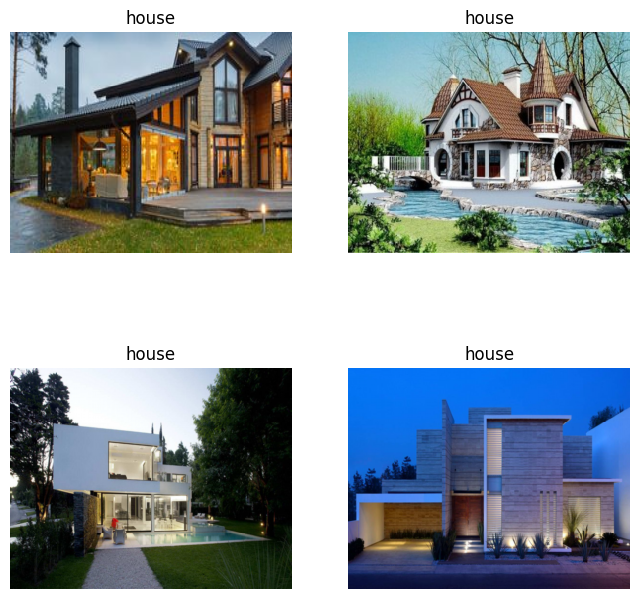

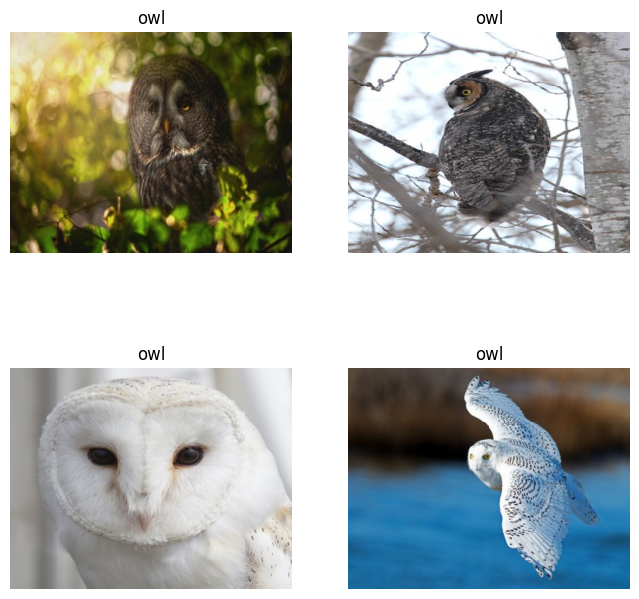

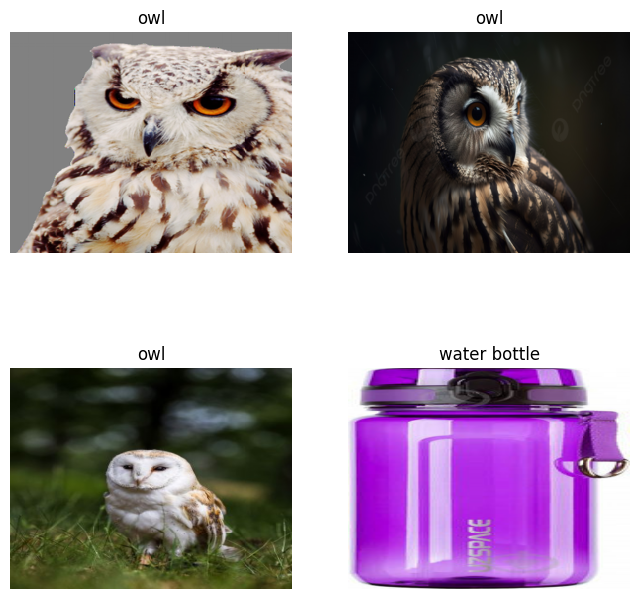

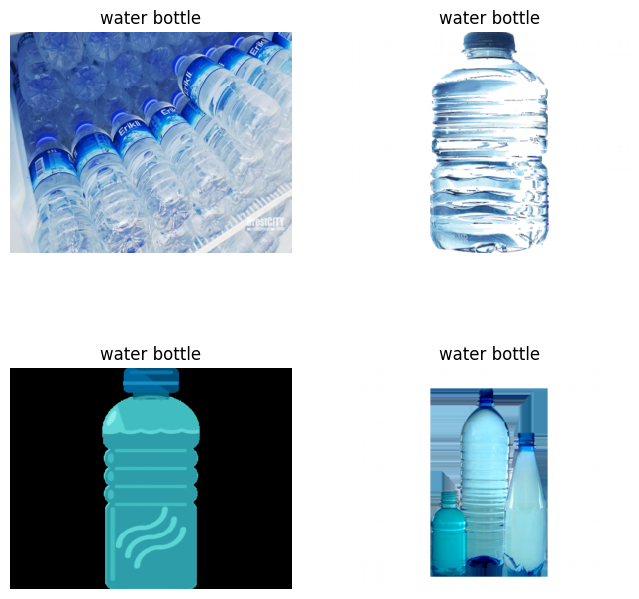

In [34]:
import PIL

with torch.no_grad():
    for images, labels in final_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = [x.argmax() for x in pretrained_model(images)]

        pred_labels = [final_dataset.classes[x] for x in preds]
        true_labels = [final_dataset.classes[x] for x in labels]

        figure = plt.figure(figsize=(8, 8))
        cols, rows = 2, 2
        for i in range(1, cols * rows + 1):
            img, pred, true = images[i].cpu(), pred_labels[i], true_labels[i]
            figure.add_subplot(rows, cols, i)
            plt.title(pred if pred == true else f"{true} (predicted {pred})")
            plt.axis("off")
            plt.imshow(torch.moveaxis(img, [0, 1, 2], [2, 0, 1]))
    plt.show()


**Правильно ли модель классифицировала ваше изображение?**

Ваш ответ: Да, правильно.

**Какая итоговая точность работы вашей модели на тестовой выборке?**

Ваш ответ:

In [35]:
import PIL

count = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        preds = [x.argmax().item() for x in pretrained_model(images).cpu()]
        for x, y in zip(preds, labels):
            if x == y:
                total += 1
            count += 1



In [36]:
f'{total / count * 100}%'

'100.0%'

**Чем отличается прием извлечения признаков от дообучения?**

Ваш ответ: В случае с извлечением признаков изменяется только последний слой модели — классификатор, тогда как при дообучении подстраиваются несколько слоёв модели, что приводит к изменению её поведения.